# Loading Image

In [2]:
from PIL import Image, ImageEnhance
import numpy as np
import cv2

In [3]:
image = Image.open(r"D:\Virtual Environments\Pattern Recognition\raw dataset\Tomato___Bacterial_spot\Tomato___Bacterial_spot90.jpg").convert('RGB')
image_np = np.array(image)

# Visualization Function

In [17]:
import matplotlib.pyplot as plt
def visualize(original, updated, title1 = '' , title2 = ''):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title(title1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title(title2)
  plt.imshow(updated)
  
  plt.subplots_adjust(wspace=1)
  plt.show()

# Preprocessing

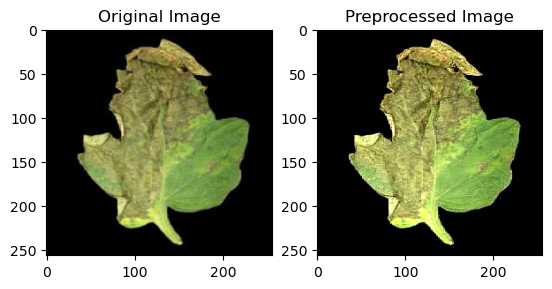

In [6]:
# Convert from RGB to BGR for OpenCV denoising
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
            
# Apply denoising using fastNlMeansDenoisingColored
denoised_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, 
                                                None, 
                                                h=2, 
                                                hColor=2, 
                                                templateWindowSize=17, 
                                                searchWindowSize=21)
 # Convert back to RGB
denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)
            
# Normalize the image (min-max normalization)
norm_img = (denoised_rgb - denoised_rgb.min()) / (denoised_rgb.max() - denoised_rgb.min()) * 255.0
norm_img = norm_img.astype(np.uint8)
processed_image = Image.fromarray(norm_img)
            
# Enhance image sharpness to improve details
sharpness_controller = ImageEnhance.Sharpness(processed_image)
processed_image = sharpness_controller.enhance(2.5)  

contrast_controller = ImageEnhance.Contrast(processed_image)
processed_image = contrast_controller.enhance(1.1)  

brightness_controller = ImageEnhance.Brightness(processed_image)
processed_image = brightness_controller.enhance(1.1)  

visualize(image , processed_image, 'Original Image', 'Preprocessed Image')

# Segmentation

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from rembg import remove

def segment_leaf_image_processing(image):
    """Segments the leaf from the background using color filtering."""
    image_np = np.array(image)  # Convert image to NumPy array
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Define green color range
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    healthy_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_CLOSE, kernel)
    healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_OPEN, kernel)

    # Find and extract the largest contour
    contours, _ = cv2.findContours(healthy_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_mask = np.zeros_like(healthy_mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(leaf_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return leaf_mask

def identify_affected_regions(image, leaf_mask):
    """Identifies affected regions on the leaf based on color thresholding."""
    image_np = np.array(image)
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Define affected region color range
    lower_affected = np.array([10, 50, 50])
    upper_affected = np.array([25, 255, 255])

    affected_mask = cv2.inRange(hsv, lower_affected, upper_affected)
    affected_mask = cv2.bitwise_and(affected_mask, affected_mask, mask=leaf_mask)

    return affected_mask

def extract_affected_region(image, leaf_mask, affected_mask):
    """Extracts affected areas and removes background."""
    image_np = np.array(image)
    non_green_mask = cv2.bitwise_not(leaf_mask)
    combined_mask = cv2.bitwise_or(non_green_mask, affected_mask)
    combined_region = cv2.bitwise_and(image_np, image_np, mask=combined_mask)

    # Handle transparency (if RGBA)
    if image_np.shape[-1] == 4:
        combined_region[combined_mask == 0, 3] = 0  # Set transparent pixels
    else:
        combined_region[combined_mask == 0] = [255, 255, 255]  # Set background to white

    return Image.fromarray(combined_region)

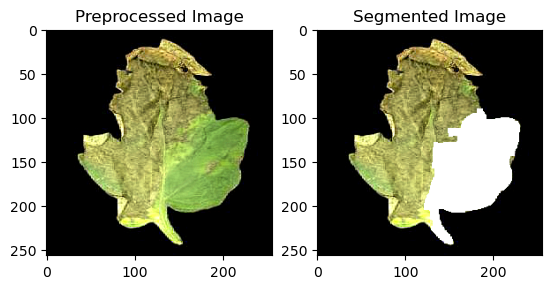

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from rembg import remove

image = processed_image.convert("RGB")

leaf_mask = segment_leaf_image_processing(image)
affected_mask = identify_affected_regions(image, leaf_mask)
combined_region_image = extract_affected_region(image, leaf_mask, affected_mask)
segmented_image = combined_region_image

if combined_region_image.mode == 'RGBA':
    combined_region_image = combined_region_image.convert('RGB')

visualize(image, segmented_image, 'Preprocessed Image', 'Segmented Image')

# Prediction

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image
class_names = {0: 'Tomato_Bacterial_spot', 1: 'Tomato_Early_blight', 2: 'Tomato_healthy', 3: 'Tomato_Late_blight', 4: 'Tomato_Leaf_Mold',
               5: 'Tomato_Septoria_leaf_spot', 6: 'Tomato_Two-spotted_spider_mite', 7: 'Tomato_Target_Spot', 8: 'Tomato_mosaic_virus', 9: 'Tomato_Yellow_Leaf_Curl_Virus'}
# Replace with your actual model directory (SavedModel format)
model_path = r"D:\Virtual Environments\Pattern Recognition\Models\EfficientNet"
loaded_model = tf.saved_model.load(model_path)
infer = loaded_model.signatures["serving_default"]

IMAGE_SIZE = (256, 256)  
img = segmented_image.convert("RGB")
img = img.resize(IMAGE_SIZE)
img_array = np.array(img, dtype=np.float32)
# Normalize (if needed by your model). Here assuming scaling pixel values to [0,1]
img_array /= 255.0  
# Expand dims to create batch of size 1
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, axis=0)

# Run inference
predictions = infer(img_tensor)
if isinstance(predictions, dict):
    predictions = list(predictions.values())[0]

# Convert softmax probabilities to predicted class index
predictions_np = predictions.numpy()
predicted_class = np.argmax(predictions_np, axis=1)[0]

print("Predicted class:", class_names.get(predicted_class, "Unknown"))

Predicted class: Tomato_Yellow_Leaf_Curl_Virus


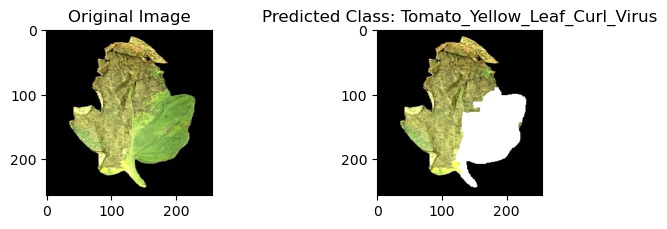

In [18]:
visualize(image, segmented_image, 'Original Image', 'Predicted Class: ' + class_names.get(predicted_class, "Unknown"))